### Consensus model using following algorithm

Online aggregation method for bounding box class labels (adapted from [Burke 2020](https://www.raillab.org/publication/burke-2020-confident/burke-2020-confident.pdf))

1. Initialize each agent accuracy as `Beta(a,b)`
2. Collect labels as bounding box on image while making note of labeller
3. Group labels from one event into one 'super label'
4. Iterate over each pixel and update the likelihood it belongs to a certain class with the following formulas:
        (excuse the markdown math)

        Prob(In class | labels) = product( Prob(label| In class)) / [product( Prob(label| In class)) + product( Prob(label| Not In class))]
                               = product(Beta(label + a, 1- label + b)) / [product(Beta(label + a, 1- label + b)) + product(Beta(1 - label + a, label + b))]
5. Iterate over each pixel and decide whether it is in the class, store decison in C
6. Iterate over each pixel and calculate the confidence of the measurement with the following formulas:\
        confidence = |Prob(In class | labels) - (1-C)|
7. Update Agent accuracy with the following formula:
        a_n+1 = a_n + SUM(is_correct*confidence)/number_of_pixels
        b_n+1 = b_n + SUM(is_incorrect*confidence)/number_of_pixels
8. continue collecting samples until all predicitons are over a confidence threshold

        


In [752]:
# imports

from PIL import Image
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import beta

#### Define Classes to Add Dummy Data

In [753]:
class Labeler():

    def __init__(self, id:int, initial_accuracy: dict[list[float]]):
        self.id = id
        self.accuracy = initial_accuracy

class Label():

    def __init__(self, id:int, label_class:str, labeler: Labeler, coordinates: list[int]):
        self.id = id
        self.label_class = label_class
        self.labeler = labeler
        self.coordinates = coordinates # Top Left x, TL y, Bottom Right x, BR y


#### Create Dummy Data

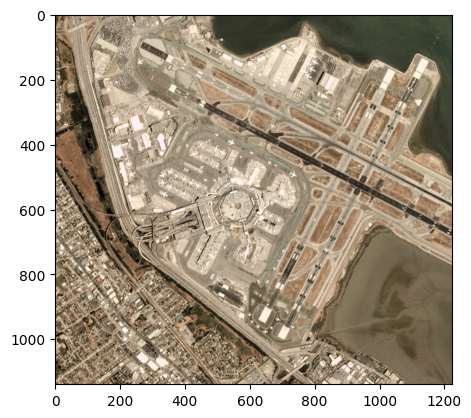

In [754]:
num_labelers = 10
labelers = [Labeler(i, initial_accuracy={"airplane": [1.4,1]}) for i in range(num_labelers)]

image = np.asarray(Image.open("airport.png"))

plt.imshow(image)


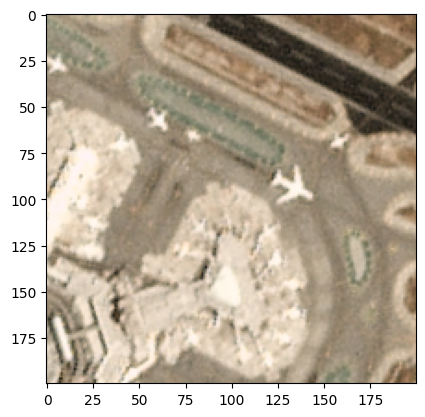

In [755]:
image = np.asarray(Image.open("airport.png").crop((600,400,800,600)))
plt.imshow(image)

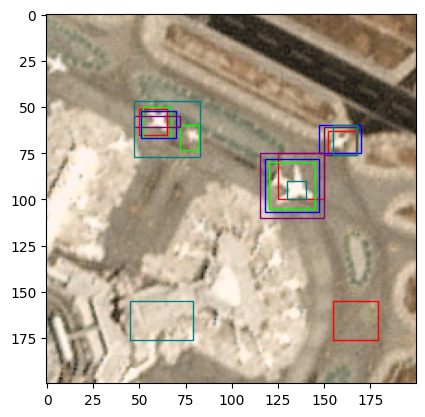

In [756]:
# add labels
labels:Label = []
#---labeller 1
labels.append(Label(0, "airplane", labelers[0], [125,75,150,100]))
labels.append(Label(1, "airplane", labelers[0], [50,51,65,65]))
labels.append(Label(2, "airplane", labelers[0], [152,63,167,75]))
labels.append(Label(3, "airplane", labelers[0], [155,155,179,176]))
#---labeller 2
labels.append(Label(4, "airplane", labelers[1], [120,80,145,105]))
labels.append(Label(5, "airplane", labelers[1], [52,50,67,67]))
labels.append(Label(6, "airplane", labelers[1], [150,61,168,76]))
labels.append(Label(7, "airplane", labelers[1], [72,60,82,73]))
#---labeller 3
labels.append(Label(8, "airplane", labelers[2], [118,78,147,107]))
labels.append(Label(9, "airplane", labelers[2], [51,52,70,67]))
labels.append(Label(10, "airplane", labelers[2], [147,60,170,75]))
#---labeller 4
labels.append(Label(11, "airplane", labelers[3], [115,75,150,110]))
labels.append(Label(12, "airplane", labelers[3], [47,55,72,61]))
labels.append(Label(13, "airplane", labelers[3], [150,61,168,76]))
#--- labeller 5
labels.append(Label(14, "airplane", labelers[4], [130,90,140,100]))
labels.append(Label(15, "airplane", labelers[4], [47,47,83,77]))
labels.append(Label(16, "airplane", labelers[4], [155,60,168,76]))
labels.append(Label(17, "airplane", labelers[4], [45,155,79,176]))



# prepate bounding boxes to be added to image
bounding_boxes = []
# for identifying labeler responsible for label
colors = [[1,0,0],
          [0,1,0],
          [0,0,1],
          [0.5,0,0.5],
          [0,0.5,0.5]]
fig, ax = plt.subplots()
ax.imshow(image)

for label in labels:
    bounding_boxes.append(patches.Rectangle(label.coordinates[0:2], label.coordinates[2]-label.coordinates[0], label.coordinates[3]-label.coordinates[1], linewidth=1, edgecolor=colors[label.labeler.id], facecolor='none'))

for bounding_box in bounding_boxes:
    ax.add_patch(bounding_box)

plt.show()


#### Generate Likelihoods of a pixel being correctly labeled

In [757]:
class ImageClassMeasure:
    # contains the values necessary to calculate the probability for each pixel to be a given label
    def __init__(self, label:str, threshold:float = 0.6):
        self.likelihoods = [[0.5] * len(image[0]) for _ in range(len(image))]
        self.confidence = [[0.0] * len(image[0]) for _ in range(len(image))]
        self.helper_values = [[[0.5,0.5] for _ in range(len(image[0]))] for _ in range(len(image))] # running total for P(w_i | L = 0) & P(w_i | L = 1)
        self.label_value = [[0.0] * len(image[0]) for _ in range(len(image))]
        self.label = label
        self.threshold = threshold

def update_label_likelihood(values: ImageClassMeasure, labels:list[Label], limits):
    # modifies the probabilities of each pixel being in the class based on a new set of labels made by the same labeler
    # can be ported to GPU if performance requires

    a = labels[0].labeler.accuracy.get(values.label)[0]
    b = labels[0].labeler.accuracy.get(values.label)[1]

    for row in range(limits[1],limits[3]):
        for col in range(limits[0],limits[2]):
            class_prediction = 0
            for label in labels:
                if (col >= label.coordinates[0] and col <= label.coordinates[2] and row >= label.coordinates[1] and row <= label.coordinates[3]):
                    class_prediction = 1
            values.helper_values[row][col][0] *= beta(1-class_prediction + a, class_prediction + b)
            values.helper_values[row][col][1] *= beta(class_prediction + a, 1-class_prediction + b)
            values.likelihoods[row][col] = values.helper_values[row][col][1] / (values.helper_values[row][col][1] + values.helper_values[row][col][0])

    
def update_label_confidence(values: ImageClassMeasure, limits):
    for row in range(limits[1],limits[3]):
        for col in range(limits[0],limits[2]):
            prediction = 1 if values.likelihoods[row][col] > values.threshold else 0
            values.confidence[row][col] = abs(values.likelihoods[row][col] - 1 + prediction)



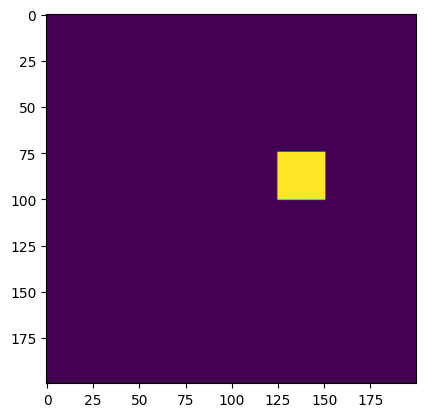

In [758]:
icm = ImageClassMeasure("airplane")

update_label_likelihood(icm, [labels[0]], [0,0, len(icm.likelihoods[0]), len(icm.likelihoods)])
update_label_confidence(icm, [0,0, len(icm.likelihoods[0]), len(icm.likelihoods)])
plt.imshow(icm.likelihoods, cmap='viridis')

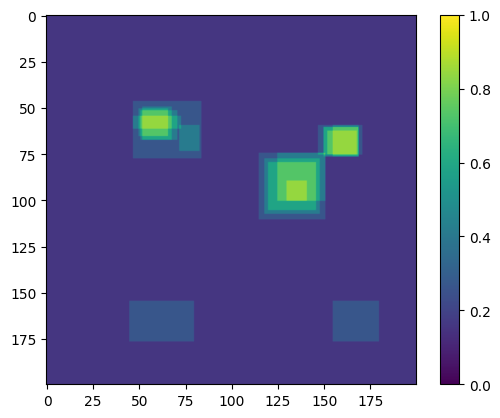

In [759]:
icm = ImageClassMeasure("airplane")
label_groups = [[labels[0],
                labels[1],
                labels[2],
                labels[3]],
                [labels[4],
                labels[5],
                labels[6],
                labels[7]],
                [labels[8],
                labels[9],
                labels[10]],
                [labels[11],
                labels[12],
                labels[13]],
                [labels[14],
                labels[15],
                labels[16],
                labels[17]],]
for group in label_groups:
    update_label_likelihood(icm, group, [0,0, len(icm.likelihoods[0]), len(icm.likelihoods)])

update_label_confidence(icm, [0,0, len(icm.likelihoods[0]), len(icm.likelihoods)])
plt.imshow(icm.likelihoods, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()


### Obtain Predictions

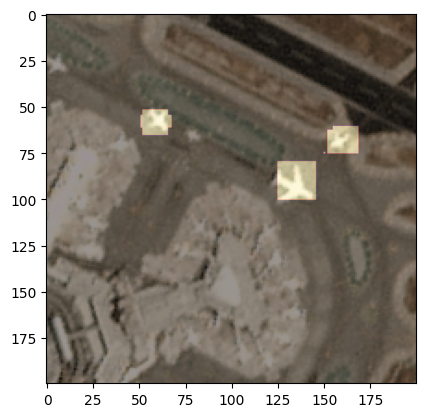

In [760]:
prediction = [[0] * len(image[0]) for _ in range(len(image))]

for row in range(len(icm.likelihoods)):
        for col in range(len(icm.likelihoods[0])):
            prediction[row][col] = 1 if icm.likelihoods[row][col] > icm.threshold else 0
plt.imshow(image)
plt.imshow(prediction, alpha=0.4, cmap='magma')

Text(0.5, 1.0, 'confidence in prediction')

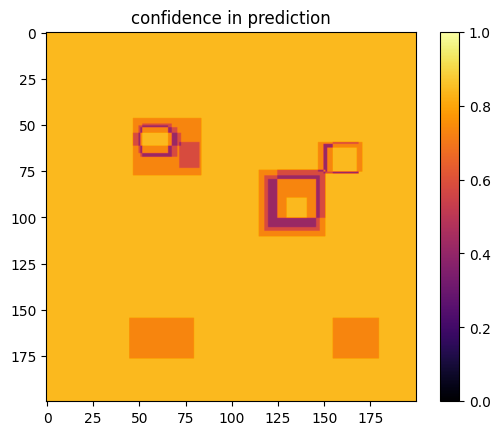

In [761]:
plt.imshow(icm.confidence, cmap='inferno', vmin=0, vmax=1)
plt.colorbar()
plt.title("confidence in prediction")

#### Update Agent Accuracy

Iterate through each pixel to get a percent accuracy, weighed by the confidence we have in a prediction

In [762]:

def update_labeler_accuracy(values: ImageClassMeasure, labels:list[Label], limits):
    # update agent accuracy based on proportion of pixels correctly labeled
    image_size = len(values.likelihoods) * len(values.likelihoods[0])
    a:float = 0
    b:float = 0

    for row in range(limits[1],limits[3]):
        for col in range(limits[0],limits[2]):
            class_prediction = 1 if icm.likelihoods[row][col] > icm.threshold else 0
            label_prediction = 0
            for label in labels:
                if (col >= label.coordinates[0] and col <= label.coordinates[2] and row >= label.coordinates[1] and row <= label.coordinates[3]):
                    label_prediction = 1
                    break
            if class_prediction == label_prediction:
                a += values.confidence[row][col]
            else:
                b += values.confidence[row][col]
    
    labels[0].labeler.accuracy[labels[0].label_class][0] += a/image_size
    labels[0].labeler.accuracy[labels[0].label_class][1] += b/image_size


for group in label_groups:
    update_labeler_accuracy(icm, group, [0,0, len(icm.likelihoods[0]), len(icm.likelihoods)])

for labeler in labelers:    
    print(f"labeler {labeler.id} has expected accuracy of {labeler.accuracy['airplane'][0]/(labeler.accuracy['airplane'][0]+labeler.accuracy['airplane'][1])*100.0:.2f}% with parameters {labeler.accuracy['airplane']}")


labeler 0 has expected accuracy of 68.56% with parameters [2.212527027727908, 1.0145372863247866]
labeler 1 has expected accuracy of 68.82% with parameters [2.2207839721723532, 1.0062803418803419]
labeler 2 has expected accuracy of 68.74% with parameters [2.218420190121076, 1.008644123931624]
labeler 3 has expected accuracy of 68.54% with parameters [2.2118834379843193, 1.0151808760683763]
labeler 4 has expected accuracy of 67.88% with parameters [2.1906377114885776, 1.0364266025641033]
labeler 5 has expected accuracy of 58.33% with parameters [1.4, 1]
labeler 6 has expected accuracy of 58.33% with parameters [1.4, 1]
labeler 7 has expected accuracy of 58.33% with parameters [1.4, 1]
labeler 8 has expected accuracy of 58.33% with parameters [1.4, 1]
labeler 9 has expected accuracy of 58.33% with parameters [1.4, 1]


#### Intelligently Select Next Region To Show
Select regions of low confidence to show to an expert

labeler 9 has expected accuracy of 80.00% with parameters [4, 1]
min confidence point is: (51, 52)


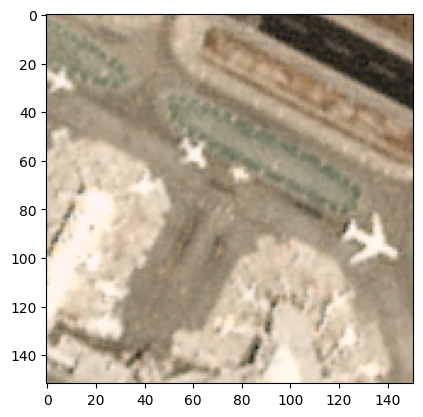

In [763]:
labelers[9].accuracy['airplane'][0] = 4
print(f"labeler {labelers[9].id} has expected accuracy of {labelers[9].accuracy['airplane'][0]/(labelers[9].accuracy['airplane'][0]+labelers[9].accuracy['airplane'][1])*100.0:.2f}% with parameters {labelers[9].accuracy['airplane']}")

# naive solution to get low confidence region
min_confidence = np.argmin(icm.confidence)
col, row = min_confidence%200, int((min_confidence-(min_confidence%200))/200)
print(f"min confidence point is: {col,row}")
crop_size = 100

def crop_image(image: npt.NDArray, center: list[int], size:int):
    # crops image and returns new origin coordinate
    left = max(center[0]-size, 0)
    top = max(center[1]-size, 0)
    right = min(center[0]+size, len(image[0]))
    bottom = min(center[1]+size, len(image))
    image2 = [row[left:right] for row in image[top:bottom]]

    return image2, [left, top, right, bottom]

image2, bounds = crop_image(image, [col,row], crop_size)
plt.imshow(image2)

    


### Collect new labels

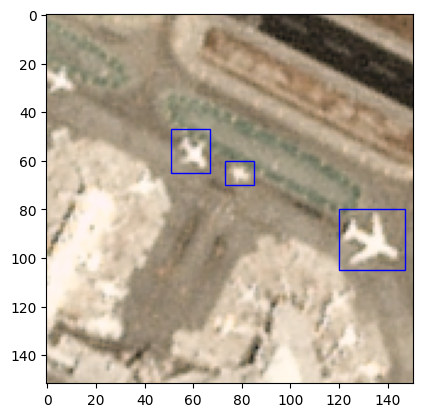

In [764]:
new_labels = []
new_labels.append(Label(18, "airplane", labelers[9], [73,60,85,70]))
new_labels.append(Label(19, "airplane", labelers[9], [51,47,67,65]))
new_labels.append(Label(20, "airplane", labelers[9], [120,80,147,105]))


# prepate bounding boxes to be added to image
bounding_boxes = []
# for identifying labeler responsible for label
colors = [[1,0,0],
          [0,1,0],
          [0,0,1],
          [0.5,0,0.5],
          [0,0.5,0.5]]
fig, ax = plt.subplots()
ax.imshow(image2)

for label in new_labels:
    bounding_boxes.append(patches.Rectangle(label.coordinates[0:2], label.coordinates[2]-label.coordinates[0], label.coordinates[3]-label.coordinates[1], linewidth=1, edgecolor=colors[2], facecolor='none'))

for bounding_box in bounding_boxes:
    ax.add_patch(bounding_box)

plt.show()

### Obtain new predictions and confidence

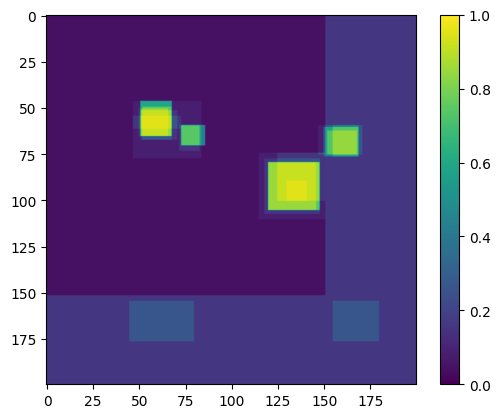

In [765]:
update_label_likelihood(icm, new_labels, bounds)
plt.imshow(icm.likelihoods, cmap='viridis', vmin=0, vmax=1)
plt.colorbar()

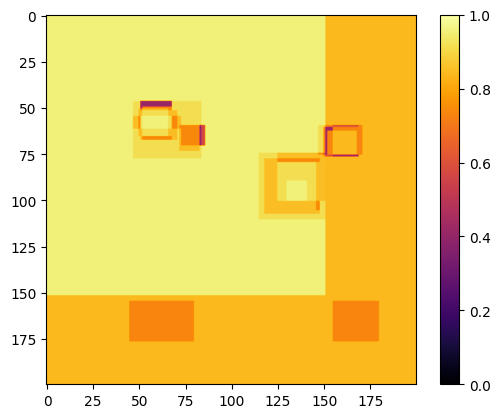

In [766]:
update_label_confidence(icm, bounds)
plt.imshow(icm.confidence, cmap='inferno', vmin=0, vmax=1)
plt.colorbar()

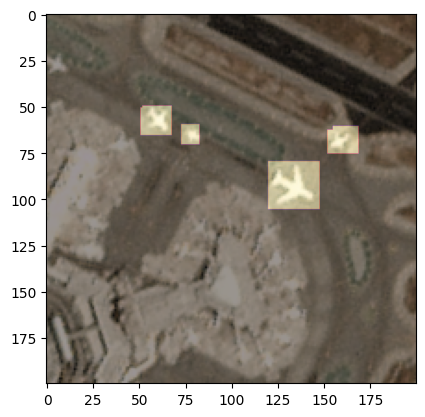

In [767]:
prediction = [[0] * len(image[0]) for _ in range(len(image))]

for row in range(len(icm.likelihoods)):
        for col in range(len(icm.likelihoods[0])):
            prediction[row][col] = 1 if icm.likelihoods[row][col] > icm.threshold else 0
plt.imshow(image)
plt.imshow(prediction, alpha=0.4, cmap='magma', vmin=0, vmax=1)